# Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import statsmodels.api as sm
from statsmodels.sandbox.regression.gmm import IV2SLS
from stargazer.stargazer import Stargazer

# Import and Clean Data

In [2]:
# import the excel data from the data subfolder that starts 
ca_21 = pd.read_excel('data/21in05ca.xlsx', header=3)[3:5]
fl_21 = pd.read_excel('data/21in10fl.xlsx', header=3)[3:5]
hi_21 = pd.read_excel('data/21in12hi.xlsx', header=3)[3:5]
mn_21 = pd.read_excel('data/21in24mn.xlsx', header=3)[3:5]
nv_21 = pd.read_excel('data/21in29nv.xlsx', header=3)[3:5]
nj_21 = pd.read_excel('data/21in31nj.xlsx', header=3)[3:5]
or_21 = pd.read_excel('data/21in38or.xlsx', header=3)[3:5]
tn_21 = pd.read_excel('data/21in43tn.xlsx', header=3)[3:5]
tx_21 = pd.read_excel('data/21in44tx.xlsx', header=3)[3:5]
wa_21 = pd.read_excel('data/21in48wa.xlsx', header=3)[3:5]

ca_16 = pd.read_excel('data/16in05ca.xls', header=3)[3:5]
fl_16 = pd.read_excel('data/16in10fl.xls', header=3)[3:5]
hi_16 = pd.read_excel('data/16in12hi.xls', header=3)[3:5]
mn_16 = pd.read_excel('data/16in24mn.xls', header=3)[3:5]
nv_16 = pd.read_excel('data/16in29nv.xls', header=3)[3:5]
nj_16 = pd.read_excel('data/16in31nj.xls', header=3)[3:5]
or_16 = pd.read_excel('data/16in38or.xls', header=3)[3:5]
tn_16 = pd.read_excel('data/16in43tn.xls', header=3)[3:5]
tx_16 = pd.read_excel('data/16in44tx.xls', header=3)[3:5]
wa_16 = pd.read_excel('data/16in48wa.xls', header=3)[3:5]


In [3]:
# create df with 2021 tax rates
tax_rates = pd.DataFrame({'State': ['California', 'Florida', 'Hawaii', 'Minnesota', 'Nevada', 'New Jersey', 'Oregon', 'Tennessee', 'Texas', 'Washington'],
                          '2021': [0.133, 0, 0.11, 0.0985, 0, 0.1075, 0.099, 0, 0, 0],
                          '2016': [0.133, 0, 0.0825, 0.0985, 0, 0.0897, 0.099, 0, 0.06, 0]})
# pivot the data
tax_rates = tax_rates.melt(id_vars='State', var_name='Year', value_name='Tax Rate')
tax_rates['Year'] = tax_rates['Year'].astype(int)

In [4]:
# clean the dataframes
list_df16 = [ca_16, fl_16, hi_16, mn_16, nv_16, nj_16, or_16, tn_16, tx_16, wa_16]
list_df21 = [ca_21, fl_21, hi_21, mn_21, nv_21, nj_21, or_21, tn_21, tx_21, wa_21]
group_t = ['California', 'Hawaii', 'Minnesota', 'New Jersey', 'Oregon']

list_of_lists = [list_df16, list_df21]

for i, list_df in enumerate(list_of_lists):
    for df in list_df:
        # sum the returns in the columns
        df['State'] = df.iloc[0,0]
        df['State'] = df['State'].str.title()
        df.drop(index=3, inplace=True)
        
        # add year column
        if i == 0:
            df['Year'] = 2016
        else:
            df['Year'] = 2021
        
        df['Total Returns'] = df.iloc[:,2:12].sum(axis=1)
        if (df.iloc[:,1] != df['Total Returns']).all() != 0:
            print(f"error in {df['State'].item()}, year {df['Year'].item()}, discrepancy of {(df.iloc[:,1] - df['Total Returns']).item():.0f} using the calculated total")
        df.drop(columns=df.columns[1:11], inplace=True)
        df.rename(columns={'$1,000,000\nor\nmore': 'High Income Returns', 'Unnamed: 0': 'Series Name'}, inplace=True)
        df['High Income Share'] = df['High Income Returns'] / df['Total Returns']
        df['High Income Share (%)'] = df['High Income Share']*100
        if df['State'].item() in group_t:
            df['Treatment'] = True
        else:
            df['Treatment'] = False


error in Florida, year 2016, discrepancy of -10 using the calculated total
error in Hawaii, year 2016, discrepancy of -10 using the calculated total
error in Nevada, year 2016, discrepancy of 10 using the calculated total
error in Oregon, year 2016, discrepancy of -10 using the calculated total
error in Tennessee, year 2016, discrepancy of -10 using the calculated total
error in Texas, year 2016, discrepancy of -10 using the calculated total
error in Washington, year 2016, discrepancy of -10 using the calculated total
error in California, year 2021, discrepancy of -10 using the calculated total
error in Hawaii, year 2021, discrepancy of -10 using the calculated total
error in Minnesota, year 2021, discrepancy of 10 using the calculated total
error in Oregon, year 2021, discrepancy of -10 using the calculated total
error in Tennessee, year 2021, discrepancy of -10 using the calculated total


In [5]:
# concatenate the dataframes
df21 = pd.concat(list_df21)
df16 = pd.concat(list_df16)

# 2.b 

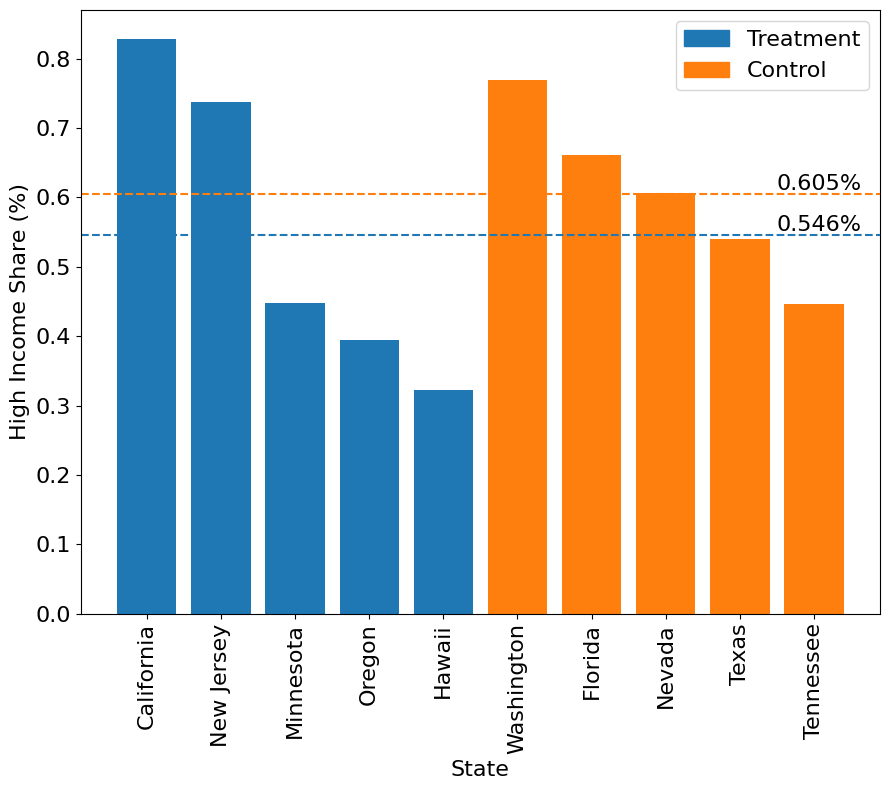

In [6]:
# prepare the data for plotting
df21.sort_values(['Treatment','High Income Share'], ascending=[False,False], inplace=True)
colors = df21['Treatment'].map({True: 'tab:blue', False: 'tab:orange'})
group_t_avg = df21[df21['Treatment']]['High Income Share (%)'].mean()
group_c_avg = df21[~df21['Treatment']]['High Income Share (%)'].mean()

# plot the data
plt.figure(figsize=(9,8))
plt.bar(df21['State'], df21['High Income Share (%)'], color=colors)
plt.axhline(y=group_t_avg, color='tab:blue', linestyle='--')
plt.axhline(y=group_c_avg, color='tab:orange', linestyle='--')

# add the average as text to the plot
plt.text(8.5, group_t_avg, f'{group_t_avg:.3f}%', verticalalignment='bottom', fontsize=16)
plt.text(8.5, group_c_avg, f'{group_c_avg:.3f}%', verticalalignment='bottom', fontsize=16)

plt.ylabel('High Income Share (%)', fontsize=16)
plt.xlabel('State', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=90)
group_t_patch = mpatches.Patch(color='tab:blue', label='Treatment')
group_c_patch = mpatches.Patch(color='tab:orange', label='Control')
plt.legend(handles=[group_t_patch, group_c_patch], fontsize=16)
plt.tight_layout()
plt.savefig('high_income_share_by_state.png')
plt.show()

# 2.b

In [7]:
# create one dataframe with all the data
df = pd.concat([df16, df21], axis=0)
df = pd.merge(df, tax_rates, on=['State','Year'])

# add post and interaction variable
df['2021'] = df['Year'].map({2016: 0, 2021: 1})
df['Treatmentx2021'] = df['2021'] * df['Treatment']

df['High Income Share'] = df['High Income Share'].astype(float)
df['High Income Share (%)'] = df['High Income Share (%)'].astype(float)
df['Treatment'] = df['Treatment'].astype(int)

df['Net of Tax'] = 1-df['Tax Rate']

# set log to be zero for 2016 and the log of the net of tax for 2021
df['log_net_of_tax'] = np.log(df['Net of Tax'])
df.loc[df['Year'] == 2016, 'log_net_of_tax'] = 0

df['log_HIR'] = np.log(df['High Income Returns'])


In [72]:
y = np.log(df[df['Year']==2021]['High Income Returns'])
x = sm.add_constant(df[df['Year']==2021]['log_net_of_tax'])

model0 = sm.OLS(y, x).fit()

print(model0.summary())

                             OLS Regression Results                            
Dep. Variable:     High Income Returns   R-squared:                       0.018
Model:                             OLS   Adj. R-squared:                 -0.104
Method:                  Least Squares   F-statistic:                    0.1505
Date:                 Mon, 22 Apr 2024   Prob (F-statistic):              0.708
Time:                         01:21:32   Log-Likelihood:                -15.895
No. Observations:                   10   AIC:                             35.79
Df Residuals:                        8   BIC:                             36.40
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.1542      0.5

/opt/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# 2.d

### Graph

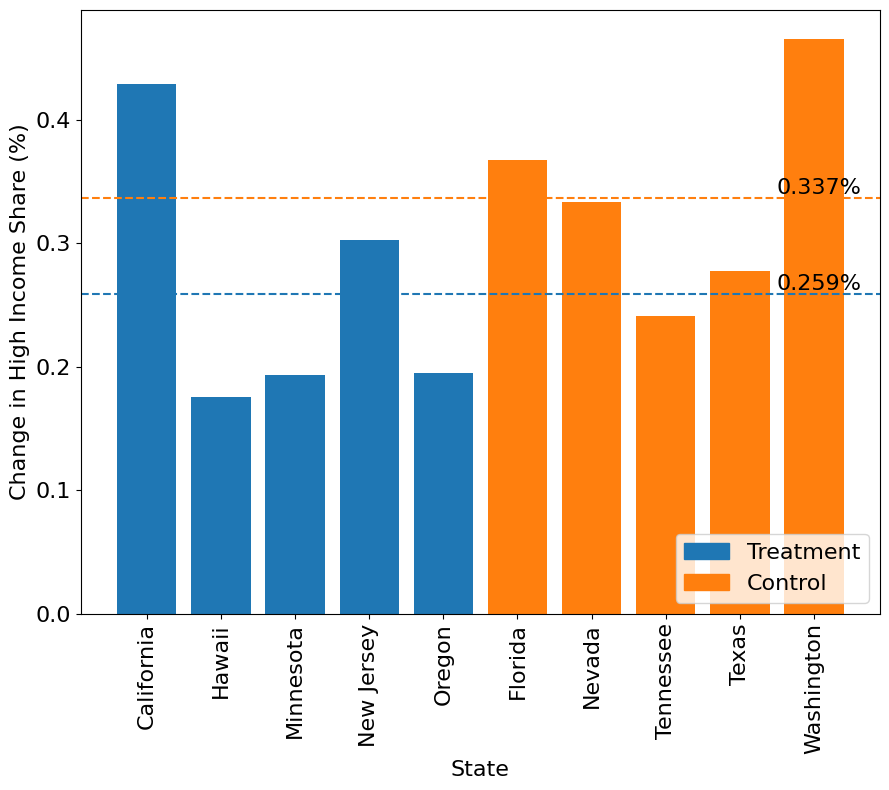

In [59]:
# show bars grouped by state to see the change in high income share
df_pivot = df.pivot(index='State', columns='Year', values='High Income Share (%)').astype(float)
df_pivot['Change'] = df_pivot[2021] - df_pivot[2016]

# add treatment variable
df_pivot['Treatment'] = df_pivot.index.isin(group_t)
df_pivot.sort_values(['Treatment','State'], ascending=[False, True], inplace=True)

colors = df_pivot['Treatment'].map({True: 'tab:blue', False: 'tab:orange'})
group_t_avg = df_pivot[df_pivot['Treatment']]['Change'].mean()
group_c_avg = df_pivot[~df_pivot['Treatment']]['Change'].mean()

plt.figure(figsize=(9,8))
plt.bar(df_pivot.index, df_pivot['Change'], color=colors)
plt.axhline(y=group_t_avg, color='tab:blue', linestyle='--')
plt.axhline(y=group_c_avg, color='tab:orange', linestyle='--')

# add the average as text to the plot
plt.text(8.5, group_t_avg, f'{group_t_avg:.3f}%', verticalalignment='bottom', fontsize=16)
plt.text(8.5, group_c_avg, f'{group_c_avg:.3f}%', verticalalignment='bottom', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=90)
group_t_patch = mpatches.Patch(color='tab:blue', label='Treatment')
group_c_patch = mpatches.Patch(color='tab:orange', label='Control')
plt.legend(handles=[group_t_patch, group_c_patch], fontsize=16, loc='lower right')


plt.ylabel('Change in High Income Share (%)', fontsize=16)
plt.xlabel('State', fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.tight_layout()

plt.savefig('change_high_income_share.png')

### Regressions

In [8]:
Y = df['log_HIR']
X1 = df[['Treatment', '2021', 'Treatmentx2021']]
X1 = sm.add_constant(X1)
model1 = sm.OLS(Y, X1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                log_HIR   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                 -0.024
Method:                 Least Squares   F-statistic:                    0.8508
Date:                Mon, 22 Apr 2024   Prob (F-statistic):              0.486
Time:                        00:03:12   Log-Likelihood:                -31.532
No. Observations:                  20   AIC:                             71.06
Df Residuals:                      16   BIC:                             75.05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.3703      0.585     16.

In [9]:
# one-hot encode the state variable
df_dummy = df.copy()
df_dummy = pd.get_dummies(df_dummy, columns=['State'], drop_first=False)
df_dummy.drop(columns=['State_Tennessee'], inplace=True)
# change type to int
df_dummy.iloc[:,-9:] = df_dummy.iloc[:,-9:].astype(int)

X2 = df_dummy[['Treatment', '2021', 'Treatmentx2021'] + list(df_dummy.columns[-9:])]
X2 = sm.add_constant(X2)
model2 = sm.OLS(Y, X2).fit(cov_kwds='HC1') # robust standard errors
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                log_HIR   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     726.9
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           9.45e-11
Time:                        00:03:27   Log-Likelihood:                 36.070
No. Observations:                  20   AIC:                            -48.14
Df Residuals:                       8   BIC:                            -36.19
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.7003      0.049  

In [10]:
# Dependent variable for the first stage
Y_first_stage = df_dummy['log_net_of_tax']

# Independent variables for the first stage
X_first_stage = sm.add_constant(df_dummy[['Treatmentx2021','Treatment', '2021'] + list(df_dummy.columns[-9:])])

# Run the first stage regression
first_stage_model = sm.OLS(Y_first_stage, X_first_stage)
first_stage_results = first_stage_model.fit()

# Save the predicted values of 'log_net_of_tax'
pred_log_net_of_tax = first_stage_results.predict(X_first_stage)


In [31]:
# Dependent variable for the second stage
Y_second_stage = df_dummy['log_HIR']

# Independent variables for the second stage, replacing 'log_net_of_tax' with its predicted values
X_second_stage = sm.add_constant(df_dummy[['Treatment', '2021','log_net_of_tax'] + list(df_dummy.columns[-9:])])
X_second_stage['log_net_of_tax'] = pred_log_net_of_tax  # Use the predicted values

# Run the second stage regression
second_stage_model = sm.OLS(Y_second_stage, X_second_stage)
model3 = second_stage_model.fit()

# Print the results from the second stage
print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:                log_HIR   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     726.9
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           9.45e-11
Time:                        00:18:06   Log-Likelihood:                 36.070
No. Observations:                  20   AIC:                            -48.14
Df Residuals:                       8   BIC:                            -36.19
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.7003      0.049  

In [78]:
# stargazer
stargazer = Stargazer([model0, model1, model2, model3])

stargazer.show_degrees_of_freedom(False)
stargazer.custom_columns(['Cross Section (2b)', 'DiD (2d)', 'DiD w. State FE (2d)', 'IV2SLS (2d)'], [1,1, 1, 1])
stargazer.covariate_order(['Treatment', '2021', 'Treatmentx2021', 'log_net_of_tax'])
stargazer.significant_digits(4)
stargazer.rename_covariates({'Treatment': 'Treatment', '2021': '2021', 'Treatmentx2021': 'Treatment x 2021', 'log_net_of_tax': 'Log Net of Tax'})


table2d = stargazer.render_latex()
table2d = table2d.replace('State_', '')
table2d = table2d.replace('%', '\%')
table2d = table2d.replace('\\textit{Note:}','% \\textit{Note:}')
table2d = table2d.replace('log_HIR', 'Log High Income Returns')
print(table2d)

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & \multicolumn{1}{c}{Cross Section (2b)} & \multicolumn{1}{c}{DiD (2d)} & \multicolumn{1}{c}{DiD w. State FE (2d)} & \multicolumn{1}{c}{IV2SLS (2d)}  \\
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Treatment & & -0.3628$^{}$ & 0.2560$^{***}$ & 0.2560$^{***}$ \\
& & (0.8279) & (0.0470) & (0.0470) \\
 2021 & & 0.9072$^{}$ & 0.9072$^{***}$ & 0.9072$^{***}$ \\
& & (0.8279) & (0.0399) & (0.0399) \\
 Treatment x 2021 & & -0.2044$^{}$ & -0.2044$^{***}$ & \\
& & (1.1708) & (0.0564) & \\
 Log Net of Tax & 2.7590$^{}$ & & & 1.7595$^{***}$ \\
& (7.1124) & & & (0.4852) \\
\hline \\[-1.8ex]
 Observations & 10 & 20 & 20 & 20 \\
 $R^2$ & 0.0185 & 0.1376 & 0.9990 & 0.9990 \\
 Adjusted $R^2$ & -0.1042 & -0.0241 & 0.9976 & 0.9976 \\
 Residual Std. Error & 1.3259 & 1.3090 & 0.0630 & 0.0630 \\
 F Statistic & 0.1505$^{}$ & 0.8508$^{}$ & 726.8516$^{***}$ & 726.8516$^{***}$ \\
